# Improvements

# Check content of NFS

In [1]:
!ls /mnt

5aa1d06c-d409-4d4a-8d4f-d90f51350047.jpg  io		      test_bc_hbp
algorithms-modern-storage-p30-petrov.pdf  O1.20181114.tar.gz  Users
circuits				  out.dat	      without_repo
entities				  test_bc_20181114


# Pull Simulation Results

In [47]:
!pip install -q --force-reinstall 'https://github.com/antonelepfl/testvue/raw/master/dynamic_analysis_pkg-0.1.1.tar.gz'

In [19]:
# Package functions
# !cat /opt/conda/envs/python2/lib/python2.7/site-packages/dynamic_analysis_pkg/__init__.py

In [20]:
# Test data already retrieved
!ls /home/jovyan/tmp/test_pull_unicore

BlueConfig  Minicolumn_report_0.bbp  out.dat


In [9]:
import dynamic_analysis_pkg
# you can change working directory or circuit
dynamic_analysis_pkg.define_paths()
# download data
# Minicolumn_report ~30 MB (13 sec)
dynamic_analysis_pkg.fetch_results(oauth.get_token(), 'SIMULATION_URL')

Simulation Name: Microcircuit - 300ms - 2 nodes
Files:
{u'BlueConfig': PathFile: BlueConfig,
 u'Minicolumn_report_0.bbp': PathFile: Minicolumn_report_0.bbp,
 u'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 u'analysis_path.json': PathFile: analysis_path.json,
 u'out.dat': PathFile: out.dat,
 u'stderr': PathFile: stderr,
 u'stdout': PathFile: stdout}
/home/jovyan/tmp/test_pull_unicore/BlueConfig created!
/home/jovyan/tmp/test_pull_unicore/Minicolumn_report_0.bbp created!
/home/jovyan/tmp/test_pull_unicore/out.dat created!


In [ ]:
LOCAL_DIR = '/home/jovyan/tmp/test_pull_unicore'

# Explore Circuit

In [13]:
# !pip install -q -i https://bbpteam.epfl.ch/repository/devpi/simple/ voxcell --force-reinstall
# !pip install -q -i https://bbpteam.epfl.ch/repository/devpi/simple/ bluepy --force-reinstall

In [14]:
from voxcell import VoxelData, RegionMap
import bluepy
from bluepy.v2.enums import Cell
from voxcell.nexus.voxelbrain import Atlas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time

In [15]:
circuit = bluepy.Circuit(join(LOCAL_DIR, 'BlueConfig'))

In [16]:
mtypes = circuit.v2.cells.mtypes
targets = ['mc'+str(idx) for idx in range(7)]

In [17]:
composition = pd.DataFrame(index=mtypes, columns=targets)
for target in targets:
    for mtype in mtypes:
        composition[target][mtype] = len(circuit.v2.cells.ids(group={Cell.MTYPE: mtype, Cell.REGION: '@'+target+'.*'}))

composition.head()

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full(18186, True) will return an array of dtype('bool')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


,mc0,mc1,mc2,mc3,mc4,mc5,mc6
SP_AA,14,11,10,15,5,13,12
SO_OLM,6,21,13,14,12,12,10
SP_CCKBC,32,26,16,30,20,29,42
SO_BS,5,6,5,4,3,1,4
SO_BP,0,0,0,0,1,1,0


In [26]:
# Get the GID of miniColumns
minicolumns = ['mc{}_Column'.format(str(idx)) for idx in range(7)]
gids_by_mc = {}
for minicolum in minicolumns:
    mcX_values = circuit.v2.cells.get(minicolum).index.get_values()
    print('Name: {} - Cells: {}'.format(minicolum, len(mcX_values)))
    gids_by_mc[minicolum] = mcX_values


Name: mc0_Column - Cells: 2556
Name: mc1_Column - Cells: 2713
Name: mc2_Column - Cells: 2495
Name: mc3_Column - Cells: 2638
Name: mc4_Column - Cells: 2582
Name: mc5_Column - Cells: 2638
Name: mc6_Column - Cells: 2564


# Connectivity

In [ ]:
def pair_coord_distance(circuit, pregid, postgid):
    p0 = circuit.v2.cells.get(pregid, [Cell.X, Cell.Y, Cell.Z]).values
    p1 = circuit.v2.cells.get(postgid, [Cell.X, Cell.Y, Cell.Z]).values
    return abs(p0-p1)

def connection_probability(circuit, pregids, postgids, zdist, xmin, xmax, nsample):
    counter = 0
    connected = 0
    exp_attempted = 0
    for idx in range(nsample):
        attempts = 0
        pregid = np.random.choice(pregids)
        # check if the cells are within the defined distance
        distant = True
        while distant:
            postgid = np.random.choice(postgids)
            # avoid to pick up the same gid
            if postgid == pregid:
                pass
            dx, _dy, dz = pair_coord_distance(circuit, pregid, postgid)
            if (dx < xmax) and (dx < xmax) and (dz < zdist):
                distant = False
            else:
                attempts += 1
            # avoid to enter in an infinit loop
            if attempts > 100:
                distant = False
                exp_attempted += 1
        if circuit.v2.stats.sample_pathway_synapse_count(1, pre=pregid, post=postgid) > 0:
                connected += 1
        if exp_attempted > 10:
            pass
    return connected/nsample

In [ ]:
bio_path = '/mnt/entities/bionames/20181114/connection_probability.txt'

In [ ]:
df = pd.read_csv(bio_path, sep='\t', index_col = False)

In [ ]:
df.head()

In [ ]:
# remove datapoint with n<10
df.drop([3, 11, 13, 17], inplace=True)

In [ ]:
nsample = 1000
nrepetitions = 3
xmax = 400
zdist = 100

In [ ]:
df['mod_mean'] = 0.0
df['mod_std'] = 0.0

In [ ]:
for index, row in df.iterrows():
    
    model_probability = np.zeros(nrepetitions)
    
    target = 'slice' + str(int(row['slice']))
    
    pre1 = circuit.v2.cells.ids(row['Pre'])
    pre2 = circuit.v2.cells.ids(target)
    pregids = np.intersect1d(pre1, pre2)
    
    post1 = circuit.v2.cells.ids(row['Post'])
    post2 = circuit.v2.cells.ids(target)
    postgids = np.intersect1d(post1, post2)
    
    if len(pregids)*len(pregids) == 0:
        print('missing mtype')
        pass
        
    for idx in range(nrepetitions):
        model_probability[idx] = connection_probability(circuit, pregids, postgids, zdist, row['xmin'], xmax, nsample)

    df.loc[index, 'mod_mean'] = model_probability.mean()
    df.loc[index, 'mod_std'] = model_probability.std()

    print(time.asctime(), row['Pre'], row['Post'], 'done')
    

# Analyze Reports

In [19]:
from bluepy.v2 import Simulation, Circuit
from bluepy.v2.enums import Cell
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
# from PyPDF2 import PdfFileMerger, PdfFileReader
import os
import pandas as pd

In [20]:
sim = Simulation(join(LOCAL_DIR, 'BlueConfig'))

In [23]:
gids = sim.circuit.cells.ids(sample=100)

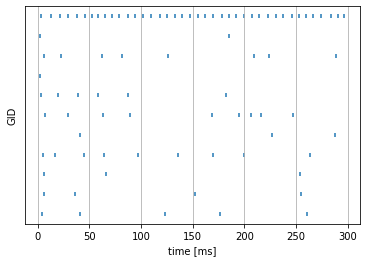

In [24]:
fig, ax = plt.subplots()
# ax = sim.v2.plot.raster(gids, groupby='mtype', t_start=0)
ax = sim.plot.raster(gids, t_start=0)
# ax.legend()
timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
plt.show()